# Import Packages

In [1]:
import os, sys, pdb
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, join
import csv
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch
from astroquery.vizier import Vizier
import warnings
from astropy.logger import AstropyWarning
warnings.filterwarnings('ignore', category=AstropyWarning)

# Define Functions

In [2]:
def get_data(catalog, join_key='Name', join_type='inner'):

    """
    PURPOSE:    Get data from literature with Vizier

    INPUT:      catalog = ctalog name on Vizier (str)
                join_key = column header to join tables, if multiple (str; optional)
                join_type = way to join tables, if multiple (str; optional)

    OUTPUT:     t = data table (AstroPy Table)

    """

    ### GET FULL CATALOG (ALL COLUMNS, ALL ROWS)
    viz = Vizier(catalog=catalog, columns=['**'])
    viz.ROW_LIMIT = -1
    tv = viz.get_catalogs(catalog)

    ### IF MULTIPLE TABLES, JOIN THEN
    for i, val in enumerate(tv.keys()):
        if i == 0:
            t = tv[val]
        else:
            tt = tv[val]
            if join_key in tt.columns:
                t = join(t, tt, join_type=join_type, keys=join_key)

    return t


def plot_grid(ax, gasgrid):

    ### GET GAS MASSES FROM GRID
    mgas = gasgrid['M_gas']

    ### GET FLUXES FROM GRID & CONVERT TO LUMINOSITY
    Lscale = 4 * np.pi * 140.**2
    xplot = Lscale * gasgrid['f_2-1_12co']
    yplot = Lscale * gasgrid['f_2-1_13co']

    ### PLOT GRID POINTS
    mgas_list = ['3e-2', '1e-2', '3e-3', '1e-3', '3e-4', '1e-4']
    mgas_col  = ['red', 'gold', 'c', 'b', 'm', 'k']
    labels = np.chararray(len(mgas_list))
    for i, val in enumerate(mgas_list):
        indx = (mgas == float(val))
        x,y = xplot[indx], yplot[indx]
        ax.plot(x, y, 'o', alpha=0.25, mec='none', color=mgas_col[i], ms=8)

    ### PLOT LEGENDS
    ax.text(1.6e5, 1.3e6, 'Gas Masses', ha='right', size=18)
    ax.text(1.3e5, 1e6, mgas_list[0][0] + r'$\mathregular{\times 10^{-}}$'+ r'$^{}$'.format(mgas_list[0][3]) + r'$\mathregular{M_{\odot}}$', fontsize=14, ha='right')
    ax.plot(3.6e4, 1.08e6, 'o', alpha=0.8, mec='none', color=mgas_col[0], ms=8)
    ax.text(1.3e5, 8.131e5, mgas_list[1][0] + r'$\mathregular{\times 10^{-}}$'+ r'$^{}$'.format(mgas_list[1][3]) + r'$\mathregular{M_{\odot}}$', fontsize=14, ha='right')
    ax.plot(3.6e4, 8.8e5, 'o', alpha=0.8, mec='none', color=mgas_col[1], ms=8)
    ax.text(1.3e5, 6.607e5, mgas_list[2][0] + r'$\mathregular{\times 10^{-}}$'+ r'$^{}$'.format(mgas_list[2][3]) + r'$\mathregular{M_{\odot}}$', fontsize=14, ha='right')
    ax.plot(3.6e4, 7.15e5, 'o', alpha=0.8, mec='none', color=mgas_col[2], ms=8)
    ax.text(1.3e5, 5.370e5, mgas_list[3][0] + r'$\mathregular{\times 10^{-}}$'+ r'$^{}$'.format(mgas_list[3][3]) + r'$\mathregular{M_{\odot}}$', fontsize=14, ha='right')
    ax.plot(3.6e4, 5.755e5, 'o', alpha=0.8, mec='none', color=mgas_col[3], ms=8)
    ax.text(1.3e5, 4.365e5, mgas_list[4][0] + r'$\mathregular{\times 10^{-}}$'+ r'$^{}$'.format(mgas_list[4][3]) + r'$\mathregular{M_{\odot}}$', fontsize=14, ha='right')
    ax.plot(3.6e4, 4.7e5, 'o', alpha=0.8, mec='none', color=mgas_col[4], ms=8)
    ax.text(1.3e5, 3.548e5, mgas_list[5][0] + r'$\mathregular{\times 10^{-}}$'+ r'$^{}$'.format(mgas_list[5][3]) + r'$\mathregular{M_{\odot}}$', fontsize=14, ha='right')
    ax.plot(3.6e4, 3.8e5, 'o', alpha=0.8, mec='none', color=mgas_col[5], ms=8)
    box = FancyBboxPatch((3e4, 3.2e5), 1.5e5, 13e5,boxstyle=mpatches.BoxStyle("Round", pad=0.02),fc="none",ec="k")
    ax.add_patch(box)


def plot_data(ax, dist, l12, f12, e12, l13, f13, e13):


    """
    PURPOSE:    Plot the gas data

    INPUT:      ax = matplotlib ax for plotting 
                dist = distance to source in pc (float)
                l13/12 = limit flag for 13CO/12C0 flux (str arr)
                f13/12 = flux for 13CO/12CO flux (float arr)
                e13/12 = flux error for 13CO/12CO flux (float arr)

    OUTPUT:     None

    """

    ### SCALE FLUXES TO LUMINOSITIES
    Lscale = 4. * np.pi * (dist**2) 
    L13   = Lscale * f13 / 1000.0
    L12   = Lscale * f12 / 1000.0

    ### SCALE FLUX ERRORS TO LUMINOSITIES AND INCLUDE CALIBRATION ERROR
    calerr = 0.10 
    e_L13  = Lscale * np.sqrt( (calerr * f13 / 1000.0)**2 + (e13 / 1000.0)**2 )
    e_L12  = Lscale * np.sqrt( (calerr * f12 / 1000.0)**2 + (e12 / 1000.0)**2 )

    ### SET FLUXES FROM IMAGE STACKS
    L_13_lim1  = Lscale * 14. / 1e3
    L_12_lim1  = Lscale * 36. / 1e3
    
    ### PLOT STACKING RESULTS
    ax.arrow(L_12_lim1, L_13_lim1, 0.0, -0.3 * L_13_lim1, head_width=L_12_lim1 * 0.1, 
             head_length=L_13_lim1 * 0.06, fc='black', ec='black', lw=4, zorder=999)
    ax.plot(L_12_lim1, L_13_lim1, '*', ms=30, mec='black', mfc='white', mew=3.5, zorder=1000)

    ### PLOT DATA
    for i, val in enumerate(l12):

        ### DO NOT PLOT NON-DETECTIONS IN BOTH LINES
        if (l12[i] == '<') and (l13[i] == '<'):
            continue

        ### PLOT NON-DET IN JUST 13CO
        elif l13[i] == '<':
            ax.errorbar(L12[i], L13[i], xerr=e_L12[i], fmt='o', mfc='white', ms=12, mec='black', mew=3, ecolor='black', elinewidth=3, zorder=20, capsize=3)
            ax.arrow(L12[i], L13[i], 0.0, -0.3 * L13[i], head_width=L12[i] * 0.1, head_length=L13[i] * 0.06, fc='black', ec='black', linewidth=4, zorder=10)

        ### PLOT DETECTIONS IN BOTH LINES
        else:
            ax.errorbar(L12[i], L13[i], xerr=e_L12[i], yerr=e_L13[i], fmt='o', mfc='white', ms=12,
                        mec='black', mew=3, ecolor='black', elinewidth=3, zorder=20, capsize=3)
 

# Code

Load in Sigma Orionis data

In [3]:
T = get_data("J/AJ/153/240")

Get gas grid from [Williams & Best (2014)](10.1088/0004-637X/788/1/59)

In [4]:
gasgrid = Table.read('../data/gasgrid.csv', format='ascii.csv')

Setup and create plot

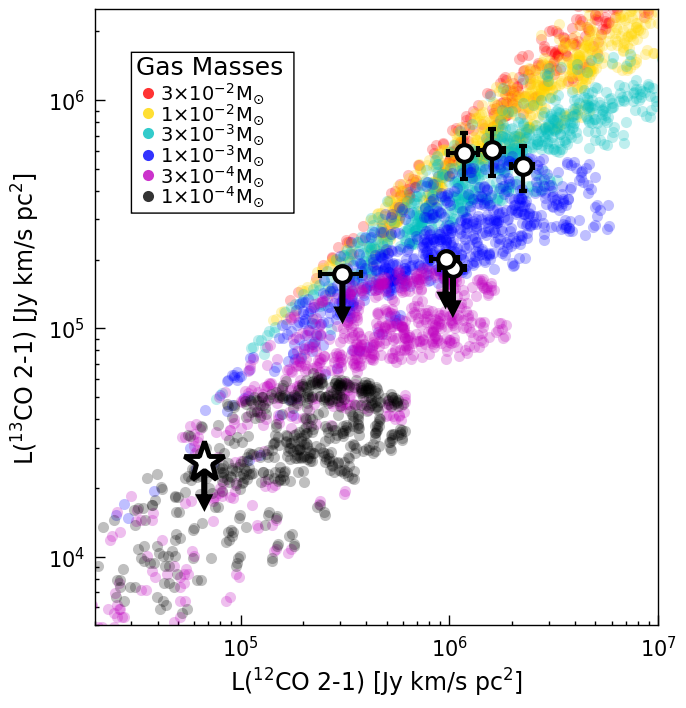

In [5]:
### SETUP PLOT
mpl.rc('xtick', labelsize=15) 
mpl.rc('ytick', labelsize=15)
mpl.rc('xtick.major', size=7, pad=7, width=1)
mpl.rc('ytick.major', size=7, pad=7, width=1)
mpl.rc('axes', linewidth=1)
mpl.rc('lines', markersize=5)
mpl.rc('xtick.minor', size=3, width=1)
mpl.rc('ytick.minor', size=3, width=1)
fig = plt.figure(figsize = (16, 8))
xlim = (2e4, 1e7)
ylim = (xlim[0]/4, xlim[1]/4)
lxlim = np.log10(xlim)
lylim = np.log10(ylim)

### PLOT ISM ABUNDANCE
ax = fig.add_subplot(121)
ax.set_xlim(xlim)
ax.set_xscale('log')
ax.set_ylim(ylim)
ax.set_yscale('log')
ax.tick_params(axis='both', which='both', direction='in')
ax.set_ylabel(r'$\mathregular{L(^{13}CO}$' + ' 2-1) [Jy km/s ' + r'$\mathregular{pc^{2}]}$', fontsize=17)
ax.set_xlabel(r'$\mathregular{L(^{12}CO}$' + ' 2-1) [Jy km/s ' + r'$\mathregular{pc^{2}]}$', fontsize=17)
plot_grid(ax, gasgrid)
plot_data(ax, 385., T['l_F12CO'], T['F12CO'], T['e_F12CO'], T['l_F13CO'], T['F13CO'], T['e_F13CO'])

Save figure

In [6]:
fig.savefig('../output/figure_05.png', bbox_inches='tight', dpi=100)
plt.close('all')